# TextClassification-All you Need


This Notebook covers:
>1. tfidf
>2. count features
>3. logistic regression
>4. naive bayes
>5. xgboost
>6. grid search
>7. word vectors(Glove)
>8. LSTM
>9. GRU


Dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Our objective is to accurately identify the author of the sentences in the data set.

### Import Libraries

In [104]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,Dense, Activation, Dropout,Embedding,BatchNormalization,SpatialDropout1D,Bidirectional
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [22]:
df=pd.read_csv("train_multi.csv")
df.dropna(inplace=True)
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [23]:
## Check target column distribution
df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

/data/1/anaconda3/envs/jupyter_venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='author', ylabel='count'>

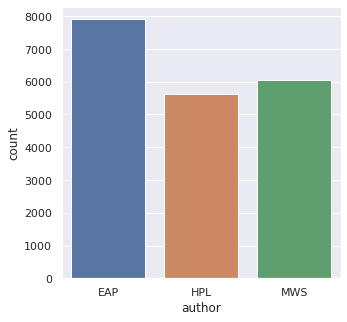

In [26]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df['author'])

### Text Cleaning

In [30]:
import re
def sanitize_text(document):
    if document == None:
        document = ""

    review_text = re.sub("[^a-zA-Z]", " ", document)
    review_text = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', review_text)
    review_text = review_text.lower()
    review_text_list = review_text.split(" ")
    review_text_list = [x.strip() for x in review_text_list]
    review_text = " ".join(review_text_list)

    document = re.sub(' +', ' ', review_text).strip()
    return document
df['clean_text']=df['text'].apply(lambda x:sanitize_text(x))

### Loss function for Multi class Classification

In [36]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    v = np.sum(actual * np.log(clip))
    return -1.0 / rows * v

### Target data Encoding

We use the LabelEncoder from scikit-learn to convert text labels to integers, 0, 1 2

In [32]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.author.values)

Before going further it is important that we split the data into training and validation sets. We can do it using train_test_split from the model_selection module of scikit-learn.

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(df.clean_text.values, 
                                                      y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [46]:
X_train.shape,X_valid.shape

((17621,), (1958,))

### Modelling

### 1. Logistic Regression with TF/IDF

In [48]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_valid))
xtrain_tfv =  tfv.transform(X_train) 
xvalid_tfv = tfv.transform(X_valid)

In [49]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, y_train)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.572 


/data/1/anaconda3/envs/jupyter_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


> Loss for LR model with TFIDF 0.572

### 2. Logistic Regression with CountVectorizer

In [50]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train) + list(X_valid))
xtrain_ctv =  ctv.transform(X_train) 
xvalid_ctv = ctv.transform(X_valid)

In [55]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, y_train)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.526 


/data/1/anaconda3/envs/jupyter_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


> Loss for LR model with CountVectorizer 0.526

### 3. MultinomialNB with TF/IDF vectorizer

In [58]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_tfv, y_train)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.577 


> Loss for Naive Bayes model with TFIDF 0.577

### 4.  MultinomialNB with Count vectorizer

In [60]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, y_train)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.485 


> Loss for Naive Bayes model with Count Vectorizer 0.485

### 5. XGBOOST with TF-IDF vectorizer

In [63]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), y_train)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

[07:17:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
logloss: 0.781 


> Loss for XGBOOST model with TFIDF 0.781

## Word Vectors
the GloVe vectors. You can download the GloVe vectors from here http://www-nlp.stanford.edu/data/glove.840B.300d.zip

In [ ]:
# !wget 'http://www-nlp.stanford.edu/data/glove.840B.300d.zip'

In [69]:
def process_glove_line(line, dim):
    word = None
    embedding = None

    try:
        splitLine = line.split()
        word = " ".join(splitLine[:len(splitLine)-dim])
        embedding = np.array([float(val) for val in splitLine[-dim:]])
    except:
        print(line)

    return word, embedding

def load_glove_model(glove_filepath, dim):
    with open(glove_filepath, encoding="utf8" ) as f:
        content = f.readlines()
        model = {}
        for line in content:
            word, embedding = process_glove_line(line, dim)
            if embedding is not None:
                model[word] = embedding
        return model

embeddings_index= load_glove_model("glove.840B.300d.txt", 300)

In [70]:
print('Found %s word vectors.' % len(embeddings_index))

Found 2195895 word vectors.


In [78]:
## Return Normalize vector of sentence
def sent2vec(s):
    
    words = word_tokenize(s)
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [79]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = np.array([sent2vec(x) for x in tqdm(X_train)])
xvalid_glove = np.array([sent2vec(x) for x in tqdm(X_valid)])




  0%|          | 0/17621 [00:00<?, ?it/s]


  1%|          | 179/17621 [00:00<00:09, 1784.95it/s]


  2%|▏         | 428/17621 [00:00<00:08, 1945.33it/s]


  4%|▍         | 676/17621 [00:00<00:08, 2078.85it/s]


  5%|▌         | 907/17621 [00:00<00:07, 2142.05it/s]


  7%|▋         | 1161/17621 [00:00<00:07, 2246.62it/s]


  8%|▊         | 1399/17621 [00:00<00:07, 2284.88it/s]


  9%|▉         | 1648/17621 [00:00<00:06, 2342.13it/s]


 11%|█         | 1905/17621 [00:00<00:06, 2404.88it/s]


 12%|█▏        | 2152/17621 [00:00<00:06, 2422.82it/s]


 14%|█▎        | 2389/17621 [00:01<00:06, 2386.51it/s]


 15%|█▍        | 2637/17621 [00:01<00:06, 2407.84it/s]


 16%|█▋        | 2876/17621 [00:01<00:06, 2283.96it/s]


 18%|█▊        | 3108/17621 [00:01<00:06, 2291.32it/s]


 19%|█▉        | 3354/17621 [00:01<00:06, 2339.09it/s]


 20%|██        | 3588/17621 [00:01<00:06, 2324.64it/s]


 22%|██▏       | 3821/17621 [00:01<00:06, 2289.78it/s]


 23%|██▎       | 4051/17621 [00:01<00:05, 229

In [81]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_glove, y_train)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

[07:41:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
logloss: 0.655 


> Loss for XGBOOST with Glove embeddings 0.655

## Deep Learning
Here, we will train a simple dense network on the GloVe features. Let's start with the dense network first:

In [82]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [84]:
from keras.utils.np_utils import to_categorical

In [86]:
# we need to binarize the labels for the neural net
ytrain_enc = to_categorical(y_train)
yvalid_enc = to_categorical(y_valid)

In [87]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [88]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Epoch 1/5


  0%|          | 0/17621 [04:46<?, ?it/s]


276/276 [==============================] - 3s 5ms/step - loss: 0.8937 - val_loss: 0.6803
Epoch 2/5
276/276 [==============================] - 1s 5ms/step - loss: 0.6744 - val_loss: 0.6447
Epoch 3/5
276/276 [==============================] - 1s 4ms/step - loss: 0.6072 - val_loss: 0.6421
Epoch 4/5
276/276 [==============================] - 1s 4ms/step - loss: 0.5635 - val_loss: 0.6381
Epoch 5/5
276/276 [==============================] - 1s 4ms/step - loss: 0.5365 - val_loss: 0.6260


> Loss of Simple DNN 0.62

### LSTM

In [95]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(X_train) + list(X_valid))
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_valid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [97]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 25076/25076 [00:00<00:00, 254826.60it/s]


In [100]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [101]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/100
35/35 [==============================] - 18s 423ms/step - loss: 1.0584 - val_loss: 0.9290
Epoch 2/100
35/35 [==============================] - 15s 442ms/step - loss: 0.9111 - val_loss: 0.7562
Epoch 3/100
35/35 [==============================] - 15s 432ms/step - loss: 0.8222 - val_loss: 0.7239
Epoch 4/100
35/35 [==============================] - 15s 435ms/step - loss: 0.7855 - val_loss: 0.6870
Epoch 5/100
35/35 [==============================] - 15s 428ms/step - loss: 0.7651 - val_loss: 0.7076
Epoch 6/100
35/35 [==============================] - 15s 437ms/step - loss: 0.7522 - val_loss: 0.6584
Epoch 7/100
35/35 [==============================] - 15s 433ms/step - loss: 0.7247 - val_loss: 0.6388
Epoch 8/100
35/35 [==============================] - 15s 428ms/step - loss: 0.7025 - val_loss: 0.6257
Epoch 9/100
35/35 [==============================] - 15s 424ms/step - loss: 0.6903 - val_loss: 0.6261
Epoch 10/100
35/35 [==============================] - 15s 439ms/step - loss: 0.676

35/35 [==============================] - 15s 431ms/step - loss: 0.2329 - val_loss: 0.5620
Epoch 81/100
35/35 [==============================] - 15s 443ms/step - loss: 0.2256 - val_loss: 0.5877
Epoch 82/100
35/35 [==============================] - 15s 424ms/step - loss: 0.2366 - val_loss: 0.5593
Epoch 83/100
35/35 [==============================] - 15s 426ms/step - loss: 0.2229 - val_loss: 0.5834
Epoch 84/100
35/35 [==============================] - 15s 424ms/step - loss: 0.2188 - val_loss: 0.5792
Epoch 85/100
35/35 [==============================] - 15s 429ms/step - loss: 0.2163 - val_loss: 0.6367
Epoch 86/100
35/35 [==============================] - 15s 421ms/step - loss: 0.2285 - val_loss: 0.5745
Epoch 87/100
35/35 [==============================] - 15s 439ms/step - loss: 0.2198 - val_loss: 0.5783
Epoch 88/100
35/35 [==============================] - 15s 429ms/step - loss: 0.2178 - val_loss: 0.5318
Epoch 89/100
35/35 [==============================] - 15s 431ms/step - loss: 0.2198 - 

> Loss of LSTM 0.59

### BI-LSTM

In [105]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
35/35 [==============================] - 42s 1s/step - loss: 1.0390 - val_loss: 0.8663
Epoch 2/100
35/35 [==============================] - 38s 1s/step - loss: 0.8562 - val_loss: 0.7310
Epoch 3/100
35/35 [==============================] - 37s 1s/step - loss: 0.7978 - val_loss: 0.7051
Epoch 4/100
35/35 [==============================] - 37s 1s/step - loss: 0.7730 - val_loss: 0.6885
Epoch 5/100
35/35 [==============================] - 37s 1s/step - loss: 0.7583 - val_loss: 0.6859
Epoch 6/100
35/35 [==============================] - 36s 1s/step - loss: 0.7330 - val_loss: 0.6708
Epoch 7/100
35/35 [==============================] - 36s 1s/step - loss: 0.7093 - val_loss: 0.6334
Epoch 8/100
35/35 [==============================] - 37s 1s/step - loss: 0.6778 - val_loss: 0.6395
Epoch 9/100
35/35 [==============================] - 38s 1s/step - loss: 0.6652 - val_loss: 0.6445
Epoch 10/100
35/35 [==============================] - 37s 1s/step - loss: 0.6276 - val_loss: 0.5824
Epoch 11/

> Loss of Bi-LSTM 0.594

### GRU

In [102]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
35/35 [==============================] - 69s 2s/step - loss: 1.0529 - val_loss: 0.8921
Epoch 2/100
35/35 [==============================] - 62s 2s/step - loss: 0.9074 - val_loss: 0.8009
Epoch 3/100
35/35 [==============================] - 61s 2s/step - loss: 0.8310 - val_loss: 0.7331
Epoch 4/100
35/35 [==============================] - 61s 2s/step - loss: 0.7911 - val_loss: 0.7018
Epoch 5/100
35/35 [==============================] - 61s 2s/step - loss: 0.7601 - val_loss: 0.6667
Epoch 6/100
35/35 [==============================] - 61s 2s/step - loss: 0.7361 - val_loss: 0.6683
Epoch 7/100
35/35 [==============================] - 60s 2s/step - loss: 0.7131 - val_loss: 0.6478
Epoch 8/100
35/35 [==============================] - 61s 2s/step - loss: 0.6855 - val_loss: 0.6154
Epoch 9/100
35/35 [==============================] - 61s 2s/step - loss: 0.6572 - val_loss: 0.5897
Epoch 10/100
35/35 [==============================] - 60s 2s/step - loss: 0.6346 - val_loss: 0.5964
Epoch 11/

> Loss of GRU  0.49